<a href="https://colab.research.google.com/github/lsteffenel/M2Atmo_et_Climat/blob/main/15-OpenSTL_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OpenSTL Tutorial

In this notebook, we will provide a comprehensive guide on how to use OpenSTL for your own project.

Firstly, we will process video data into `.npy` format for easier storage and access. Next, we will demonstrate how to utilize custom data within OpenSTL. Subsequently, we will use OpenSTL to train and evaluate models. Finally, we will visualize predicted frames and generate `.gif` images or videos.

- [0. Setup the environment](#0-setup-the-environment)

- [1. Preprocess your data](#1-process-your-data)
    - [1.1 Save the dataset](#11-save-the-dataset)
    - [1.2 Load the dataset and visualize an example](#12-load-the-dataset-and-visualize-an-example)

- [2. Utilize cumtom data](#2-utilize-cumtom-data)
    - [2.1 Define the dataset](#21-define-the-dataset)
    - [2.2 Get the dataloaders](#22-get-the-dataloaders)

- [3. Train and evaluate](#3-train-and-evaluate)
    - [3.1 Define the custom configs](#31-define-the-custom-configs)
    - [3.2 Setup the experiment](#32-setup-the-experiment)
    - [3.3 Start training and evaluation](#33)

- [4. Visualization](#4-visualization)
    - [4.1 Visualize in a line](#41-visualize-in-a-line)
    - [4.2 Generate a GIF](#42-generate-a-gif)

Here we go!

## 0. Setup the environment

In [1]:
!git clone https://github.com/chengtan9907/OpenSTL

Cloning into 'OpenSTL'...
remote: Enumerating objects: 2635, done.
remote: Counting objects: 100% (1183/1183), done.
remote: Compressing objects: 100% (296/296), done.
remote: Total 2635 (delta 1006), reused 887 (delta 887), pack-reused 1452 (from 1)
Receiving objects: 100% (2635/2635), 3.02 MiB | 20.33 MiB/s, done.
Resolving deltas: 100% (1892/1892), done.


In [2]:
import os
os.chdir('/content/OpenSTL')

!python setup.py install

/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/dist.py:261: UserWarning: Unknown distribution option: 'tests_require'
  warnings.warn(msg)
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please a

## **IMPORTANT NOTE**

Due to compatibility issues with the `python setup.py install` command in Colab, OpenSTL cannot be immediately applied to the current environment after installation.

Please **restart the session** after installation before running the following code blocks.

## 1. Process your data

Assume you possess a collection of videos and have already sorted them into the `train/`, `val/`, and `test/` directories. The subsequent step involves transforming these videos into a `.pkl` file for further manipulations.

The existing file hierarchy is as follows:

- custom_usage.ipynb
- train
  - train_example1.avi
  - train_example2.avi
- val
  - val_example1.avi
  - val_example2.avi
- test
  - test_example.avi

It's crucial to note that the above example represents a simplified scenario where we've used `.avi` videos for illustrative purposes. However, in a real-world application, you are free to employ videos in various other formats.

We utilize several videos from the KTH dataset as examples. Although the original KTH dataset consists of single-channel grayscale videos, we save them as three-channel RGB videos to accommodate a broader range of use cases.

In [4]:
!wget https://github.com/lsteffenel/M2Atmo_et_Climat/raw/refs/heads/main/data/cyclones.zip
!unzip cyclones.zip

Archive:  cyclones.zip
   creating: test/
  inflating: test/DJOUNGOU et ELEANOR - Février 2024.m4v  
  inflating: __MACOSX/test/._DJOUNGOU et ELEANOR - Février 2024.m4v  
   creating: val/
  inflating: val/DINGANI, FREDDY et ENALA - Février 2023.m4v  
  inflating: __MACOSX/val/._DINGANI, FREDDY et ENALA - Février 2023.m4v  
   creating: train/
  inflating: train/CANDICE - Janvier 2024.m4v  
  inflating: __MACOSX/train/._CANDICE - Janvier 2024.m4v  
  inflating: train/BELAL - Janvier 2024.m4v  
  inflating: __MACOSX/train/._BELAL - Janvier 2024.m4v  


### 1.1 Save the dataset

Here, we default to uniformly sampling several frames from the given video data. The number of observed frames and future frames are two hyperparameters (`pre_seq_length`, `aft_seq_length`) that are set in advance. You can also choose to sample the video in other ways and save the data.

#### hyperparameters

`pre_seq_length`: the number of given frames

`aft_seq_length`: the number of frames to predict

In [36]:
pre_seq_length = 20
aft_seq_length = 10

In [39]:
import cv2
import numpy as np
import os

def sample_frames(video_path, num_frames=200):
    # read the video
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    print("total_frames", total_frames)
    # uniformly sample frames from the video
    frame_idxs = np.linspace(0, total_frames-pre_seq_length-aft_seq_length-1, num_frames, dtype=int)
    frames = []
    for idx in frame_idxs:
        video.set(cv2.CAP_PROP_POS_FRAMES, idx)
        _, frame = video.read()
        gray = frame #cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        try:
          gray = cv2.resize(gray, (640, 360), interpolation=cv2.INTER_AREA)
          print(gray.shape)
          frames.append(gray)
        except:
          break
    video.release()
    return np.stack(frames)

def process_folder(folder_path, pre_slen=10, aft_slen=10, suffix='.avi'):
    # get all the videos in this folder
    videos = []
    files = os.listdir(folder_path)
    for file in files:
        video_path = os.path.join(folder_path, file)
        if os.path.isfile(video_path) and file.endswith(suffix):
            video = sample_frames(video_path, pre_slen + aft_slen)
            videos.append(video)
    # stack video frames from each folder
    data = np.stack(videos).transpose(0, 1, 4, 2, 3)

    # if the data is in [0, 255], rescale it into [0, 1]
    if data.max() > 1.0:
        data = data.astype(np.float32) / 255.0

    return data[:, :pre_slen], data[:, pre_slen:]

In [40]:
#import pickle
os.chdir('/content')

dataset = {}
folders = ['train', 'val', 'test']
for folder in folders:
    data_x, data_y = process_folder(folder, pre_slen=pre_seq_length, aft_slen=aft_seq_length, suffix='.m4v')
    dataset['X_' + folder], dataset['Y_' + folder] = data_x, data_y

# save as a pkl file
#with open('dataset.pkl', 'wb') as f:
#    pickle.dump(dataset, f)

total_frames 602
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
total_frames 1085
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
total_frames 1267
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640, 3)
(360, 640

### 1.2 Load the dataset and visualize an example

In [41]:
#import pickle

# load the dataset
#with open('dataset.pkl', 'rb') as f:
#    dataset = pickle.load(f)

train_x, train_y = dataset['X_train'], dataset['Y_train']
print(train_x.shape)
# the shape is B x T x C x H x W
# B: the number of samples
# T: the number of frames in each sample
# C, H, W: the height, width, channel of each frame

(1, 20, 3, 360, 640)


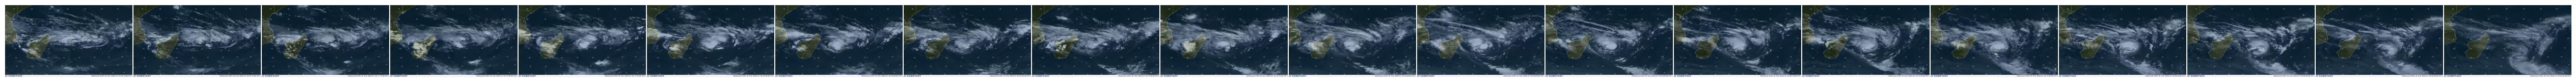

In [42]:
from openstl.utils import show_video_line

# show the given frames from an example
example_idx = 0
show_video_line(train_x[example_idx], ncols=pre_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

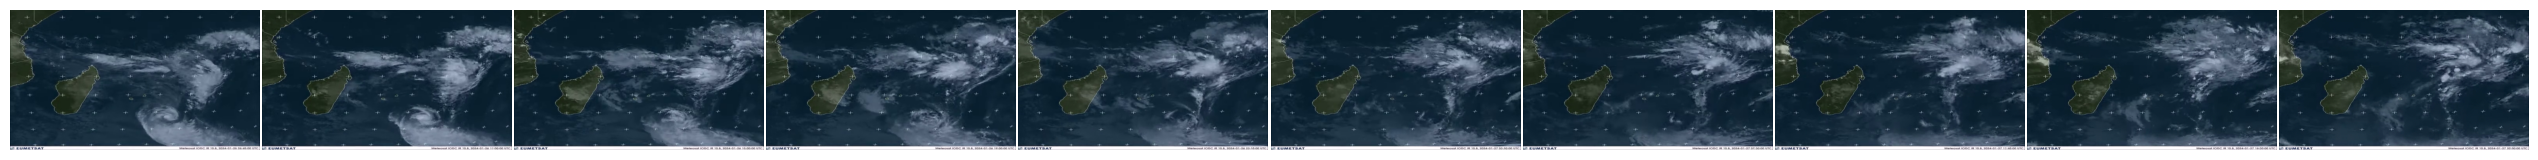

In [43]:
# show the future frames from an example
example_idx = 0
show_video_line(train_y[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

## 2. Utilize cumtom data

### 2.1 Define the dataset

We first define the `CustomDataset` to use the provided dataset.

For real video prediction, to facilitate model optimization, we strongly recommend users to use frames represented as `float32` with values in the range of $[0, 1]$, rather than frames represented as `uint8` with values in the range of $[0, 255]$. For other types of data, we also provide the option to `normalize` in the `CustomDataset`.

In [44]:
import torch
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, X, Y, normalize=False, data_name='custom'):
        super(CustomDataset, self).__init__()
        self.X = X
        self.Y = Y
        self.mean = None
        self.std = None
        self.data_name = data_name

        if normalize:
            # get the mean/std values along the channel dimension
            mean = data.mean(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            std = data.std(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            data = (data - mean) / std
            self.mean = mean
            self.std = std

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        data = torch.tensor(self.X[index]).float()
        labels = torch.tensor(self.Y[index]).float()
        return data, labels

### 2.2 Get the dataloaders

Now we can get the dataloaders by using the collected dataset and the defined `CustomDataset`.

#### hyperparameters

`batch_size`: the size of a batch

In [45]:
batch_size = 1

In [46]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = dataset['X_train'], dataset[
    'X_val'], dataset['X_test'], dataset['Y_train'], dataset['Y_val'], dataset['Y_test']

train_set = CustomDataset(X=X_train, Y=Y_train)
val_set = CustomDataset(X=X_val, Y=Y_val)
test_set = CustomDataset(X=X_test, Y=Y_test)

In [47]:
dataloader_train = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_test = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=True, pin_memory=True)

## 3. Train and evaluate

### 3.1 Define the custom configs

We first define the training configuration, which includes several important hyperparameters for training.

Here, we set `epoch = 3` as an example for simple training. The actual value of epoch in your project depends on the complexity of your dataset. Generally, a good starting point is `epoch = 100`.

Next, we define the model configuration to customize a spatio-temporal predictive learning model. For MetaVP models, the key hyperparameters are: `N_S`, `N_T`, `hid_S`, `hid_T`, and `model_type`. Users have the option to either use a config file or directly set these hyperparameters.

If a config file is preferred, the user can simply include a `config_file` key with the path to the config file in the `custom_model_config` below. Otherwise, the user can directly specify these hyperparameters in the `custom_model_config`.

In [48]:
custom_training_config = {
    'pre_seq_length': pre_seq_length,
    'aft_seq_length': aft_seq_length,
    'total_length': pre_seq_length + aft_seq_length,
    'batch_size': batch_size,
    'val_batch_size': batch_size,
    'epoch': 3,
    'lr': 0.001,
    'metrics': ['mse', 'mae'],

    'ex_name': 'custom_exp',
    'dataname': 'custom',
    'in_shape': [10, 3, 32, 32],
}

custom_model_config = {
    # For MetaVP models, the most important hyperparameters are:
    # N_S, N_T, hid_S, hid_T, model_type
    'method': 'SimVP',
    # Users can either using a config file or directly set these hyperparameters
    # 'config_file': 'configs/custom/example_model.py',

    # Here, we directly set these parameters
    'model_type': 'gSTA',
    'N_S': 4,
    'N_T': 5,
    'hid_S': 32,
    'hid_T': 64
}

### 3.2 Setup the experiment

We retrieve the default hyperparameters by utilizing `create_parser` and update those hyperparameters that are defined in `custom_training_config` and `custom_model_config`.

By utilizing `BaseExperiment`, we ensure that everything is prepared, including dataloader setup and model initialization.

In [49]:
from openstl.api import BaseExperiment
from openstl.utils import create_parser, default_parser

args = create_parser().parse_args([])
config = args.__dict__

# update default parameters
default_values = default_parser()
for attribute in default_values.keys():
    if config[attribute] is None:
        config[attribute] = default_values[attribute]

# update the training config
config.update(custom_training_config)
# update the model config
config.update(custom_model_config)

exp = BaseExperiment(args, dataloaders=(dataloader_train, dataloader_val, dataloader_test), strategy='dp')

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

### 3.3 Start training and evaluation

With everything in place, we are now ready to start training and evaluation.

Here we go!

In [ ]:
print('>'*35 + ' training ' + '<'*35)
exp.train()

print('>'*35 + ' testing  ' + '<'*35)
exp.test()

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> training <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_12.2.r12.2/compiler.33191640_0
GPU 0: Tesla T4
GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
PyTorch: 2.1.0+cu121
PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Lr: 0.0001335 | Train Loss: 0.0925540 | Vali Loss: 0.0422923


Validation: 0it [00:00, ?it/s]

Epoch 2: Lr: 0.0001335 | Train Loss: 0.1250532 | Vali Loss: 0.0398481
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> testing  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


Testing: 0it [00:00, ?it/s]

mse:121.04762268066406, mae:512.7169189453125


## Visualization

By employing the `show_video_line` and `show_video_gif_multiple` functions provided by `OpenSTL`, we can visualize the input, ground truth, and predicted frames, as well as generate corresponding GIFs.

### 4.1 Visualize in a line

In [ ]:
import numpy as np
from openstl.utils import show_video_line

# show the given frames from an example
inputs = np.load('./work_dirs/custom_exp/saved/inputs.npy')
preds = np.load('./work_dirs/custom_exp/saved/preds.npy')
trues = np.load('./work_dirs/custom_exp/saved/trues.npy')

example_idx = 0
show_video_line(trues[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

In [ ]:
example_idx = 0
show_video_line(preds[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

### 4.2 Generate a GIF

In [ ]:
from openstl.utils import show_video_gif_multiple

example_idx = 0
show_video_gif_multiple(inputs[example_idx], trues[example_idx], preds[example_idx], use_rgb=True, out_path='example.gif')